# The goal of the project:

The goal of the project is to process and analyze given data, study regarding customer behavior and test two hypotheses concerning profit. 
Hypothesis number one is that profits differ between two mobile plans given in the dataset named plans. 
Hypothesis number two is that profit from users from NY NJ area differs from profit from the other areas.

Table of contents:

Data preprocessing, change of datatypes and column names.

Study of the data using methods info(), value_counts(), describe() etc.

Merge of the first 3 dataframes and grouping it by month and user id.

Finding outliers.

Removing outliers

Merge with the 5-th df (users)

More datatype changes

Studying the new merged database and doing more processing with it

Calculating the profit for both plans

Finding the minutes, texts, and volume of data the users of each plan require per month. 

Making histograms for each relevant column. Finding variance, mean and std for each.

Splitting data by plan

Making histograms for each relevant column for each plan. Finding variance, mean and std for each.

Formulating Hypothesis number one.
Testing Hypothesis number one.
Describing results, making a conclusion. 

Formulating Hypothesis number two.
Testing Hypothesis number two.
Describing results, making a conclusion. 

Analysing customer behavior after studying all the data together and separated by plan.

Making the general conclusion.

In [ ]:
Data used:
/datasets/megaline_calls.csv

/datasets/megaline_internet.csv

/datasets/megaline_messages.csv

/datasets/megaline_plans.csv

/datasets/megaline_users.csv


# Description of the data.

## The users table (data on users):

user_id — unique user identifier

first_name — user's name

last_name — user's last name

age — user's age (years)

reg_date — subscription date (dd, mm, yy)

churn_date — the date the user stopped using the service (if the value is missing, the calling plan was being used when this data was retrieved)

city — user's city of residence

plan — calling plan name

## The calls table (data on calls):

id — unique call identifier

call_date — call date

duration — call duration (in minutes)

user_id — the identifier of the user making the call

## The messages table (data on texts):

id — unique text message identifier

message_date — text message date

user_id — the identifier of the user sending the text

## The internet table (data on web sessions):

id — unique session identifier

mb_used — the volume of data spent during the session (in megabytes)

session_date — web session date

user_id — user identifier

## The plans table (data on the plans):

plan_name — calling plan name

usd_monthly_fee — monthly charge in US dollars

minutes_included — monthly minute allowance

messages_included — monthly text allowance

mb_per_month_included — data volume allowance (in megabytes)

usd_per_minute — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)

usd_per_message — price per text after exceeding the package limits

usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from scipy import stats as st
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns

#Step 1. Open the data file and study the general information

df1 = pd.read_csv('/datasets/megaline_calls.csv')
df2 = pd.read_csv('/datasets/megaline_internet.csv')
df3 = pd.read_csv('/datasets/megaline_messages.csv')
df4 = pd.read_csv('/datasets/megaline_plans.csv')
df5 = pd.read_csv('/datasets/megaline_users.csv')

#Step 2. Prepare the data


df1.drop_duplicates(keep=False,inplace=True)
df2.drop_duplicates(keep=False,inplace=True)
df3.drop_duplicates(keep=False,inplace=True)
df4.drop_duplicates(keep=False,inplace=True)
df5.drop_duplicates(keep=False,inplace=True)



df1['call_id'] = df1['id']
df2['internet_id'] = df2['id']
df3['message_id'] = df3['id']


df1['call_date'] = pd.to_datetime(df1['call_date']) 
df1['month'] = df1['call_date'].dt.month


df2['session_date'] = pd.to_datetime(df2['session_date']) 
df2['month'] = df2['session_date'].dt.month


df3['message_date'] = pd.to_datetime(df3['message_date']) 
df3['month'] = df3['message_date'].dt.month




I changed the datatypes where necessary.
There are 2 possible reasons for data having 0 calls: first,  it can be missed calls, meaning, they technically lasted 0 seconds. Then in may be that the client's didn't use calls this month at all and only used messages and/or internet..

I decided not to drop 0.0 from calls, messages and internet since it won't change the profit anyway, even if we count it in, and also because there's so many of them, on average we shouldn't drop more than 10% of data.
Some users were using services after churn date, I decided to keep it as profit still, since they are still using the services and still paying for them.

Here I am again preparing the data and changing the relevant datatypes

In [2]:

df5['reg_date'] = pd.to_datetime(df5['reg_date']) 
df5['churn_date'] = pd.to_datetime(df5['churn_date']) 

In [3]:
df1.describe()
df1['user_id'].value_counts()
df1['duration'].value_counts() #we can see there is quite a lot of 0's
df1['month'].value_counts() #we can see that the number of entrances gets higher every month

12    30614
11    24651
10    21064
9     16523
8     13590
7     11105
6      8221
5      5959
4      3442
3      1620
2       774
1       172
Name: month, dtype: int64

In [4]:
df2.info()
df2['session_date'].value_counts()#number of entrances gets higher every month again

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104825 entries, 0 to 104824
Data columns (total 6 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null datetime64[ns]
mb_used         104825 non-null float64
internet_id     104825 non-null object
month           104825 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 5.6+ MB


2018-12-24    851
2018-12-30    845
2018-12-27    830
2018-12-21    826
2018-12-31    823
             ... 
2018-01-23      3
2018-01-20      2
2018-01-16      2
2018-01-18      2
2018-01-15      2
Name: session_date, Length: 351, dtype: int64

In [5]:
df3.info()
df3['message_date'].value_counts()#we can again see the trend of customers using the services more close to the end of the year

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76051 entries, 0 to 76050
Data columns (total 5 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null datetime64[ns]
message_id      76051 non-null object
month           76051 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 3.5+ MB


2018-12-28    702
2018-12-27    701
2018-12-31    699
2018-12-25    699
2018-12-18    688
             ... 
2018-01-28      3
2018-02-18      2
2018-01-24      2
2018-01-15      2
2018-01-19      1
Name: message_date, Length: 351, dtype: int64

In [6]:
#more preprocessing
df1['duration'] = df1['duration'].round()

In [7]:
rr = df1.groupby(['user_id', 'month']).sum().round()
rr.head()
rr1 = df1.groupby(['user_id', 'month']).count().round()
rr1 = rr1.drop(['call_date', 'id','duration'], axis=1)
rr1 = rr1.rename(columns={"call_id": "number_of_calls"})
rr1.head()
rr2 = df2.groupby(['user_id', 'month']).sum().round()
rr2.head()
rr3 = df3.groupby(['user_id','month']).count().round()
rr3 = rr3.drop(['message_date', 'id'], axis=1)
rr3 = rr3.rename(columns={"message_id": "number_of_messages"})
rr3.head()

data_frames = [rr, rr2, rr3,rr1]



In [8]:
df_merged = reduce(lambda left,right: pd.merge(left,right,on=['user_id','month'],how='outer'), data_frames).fillna(0)
#merging the first 3 dataframes and grouping it by month and user id.


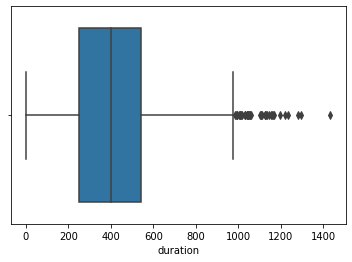

In [9]:
#looking for outliers
sns.boxplot(x=df_merged['duration'])
plt.show()

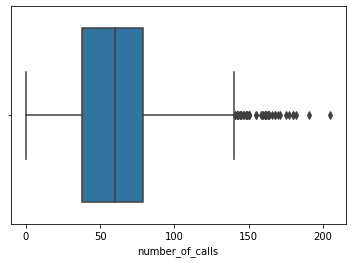

In [10]:
sns.boxplot(x=df_merged['number_of_calls'])
plt.show()

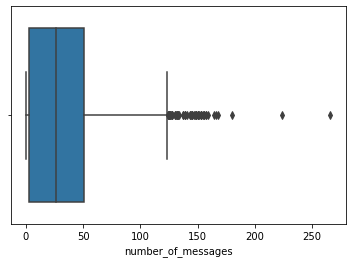

In [11]:
sns.boxplot(x=df_merged['number_of_messages'])
plt.show()

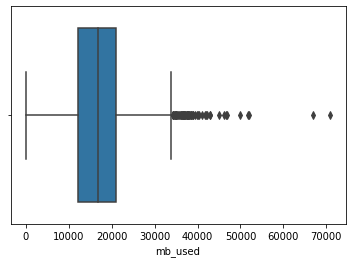

In [12]:
sns.boxplot(x=df_merged['mb_used'])
plt.show()

I decided to remove outliers based on IQR, but I believe that z-score would have yielded the same results.

In [13]:
#Removing outliers from all 4 columns in the database:
df_merged.describe()
Q1 = df_merged.quantile(0.25)
Q3 = df_merged.quantile(0.75)
IQR = Q3 - Q1

df_merged = df_merged[~((df_merged < (Q1 - 1.5 * IQR)) |(df_merged > (Q3 + 1.5 * IQR))).any(axis=1)]

df_merged.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2137 entries, (1000, 12) to (1482, 10)
Data columns (total 4 columns):
duration              2137 non-null float64
mb_used               2137 non-null float64
number_of_messages    2137 non-null float64
number_of_calls       2137 non-null float64
dtypes: float64(4)
memory usage: 77.1 KB


Something went very wrong when I was removing outliers below column by column, so I decided not to overcomplicate things and remove them here, since it should, essentially, yield the same results.

In [14]:
df_merged2 = pd.merge(left = df_merged.reset_index(), right = df5, how='left',on=['user_id'])
#merging our data with the 5-th dataframe. 

I decided not to merge with the plan dataframe because it would be confusing and we can use information from that dataframe as reference still, there is very little data.

In [15]:
cols = ['month', 'duration', 'mb_used', 'number_of_messages', 'number_of_calls']
for c in cols:
    df_merged2[c] = df_merged2[c].apply(lambda x: float(x))
df_merged2.head()  #more change to datatypes!

,user_id,month,duration,mb_used,number_of_messages,number_of_calls,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,12.0,117.0,1901.0,11.0,16.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,8.0,173.0,6919.0,30.0,27.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1001,9.0,297.0,13315.0,44.0,49.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
3,1001,10.0,374.0,22330.0,53.0,65.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
4,1001,11.0,404.0,18504.0,36.0,64.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT


Here I plot histograms and pivot tables to study consumer behavior. 

In [17]:
pd.pivot_table(df_merged2,index=['user_id','month'],values=['mb_used', 'duration', 'number_of_messages', 'number_of_calls'])


duration  mb_used  number_of_calls  number_of_messages
user_id month                                                        
1000    12.0      117.0   1901.0             16.0                11.0
1001    8.0       173.0   6919.0             27.0                30.0
        9.0       297.0  13315.0             49.0                44.0
        10.0      374.0  22330.0             65.0                53.0
        11.0      404.0  18504.0             64.0                36.0
...                 ...      ...              ...                 ...
1498    12.0      326.0  23138.0             39.0                 0.0
1499    9.0       328.0  12985.0             41.0                 0.0
        10.0      361.0  19492.0             53.0                 0.0
        11.0      287.0  16814.0             45.0                 0.0
        12.0      463.0  22059.0             65.0                 0.0

[2137 rows x 4 columns]

In [18]:
 
df_merged2['number_of_calls'] = df_merged2['number_of_calls'].round()
df_merged2['number_of_messages'] = df_merged2['number_of_messages'].round()


In [19]:
df_merged2['gb_used'] = df_merged2['mb_used']/1024
#making a column for gigabites used

In [20]:
df_merged2['gb_used'] = df_merged2['gb_used'].round()
df_merged2['gb_used'].head(10)


0     2.0
1     7.0
2    13.0
3    22.0
4    18.0
5    19.0
6     6.0
7    19.0
8    14.0
9     6.0
Name: gb_used, dtype: float64

In [21]:
df_merged2.head()

,user_id,month,duration,mb_used,number_of_messages,number_of_calls,first_name,last_name,age,city,reg_date,plan,churn_date,gb_used
0,1000,12.0,117.0,1901.0,11.0,16.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,2.0
1,1001,8.0,173.0,6919.0,30.0,27.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,7.0
2,1001,9.0,297.0,13315.0,44.0,49.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,13.0
3,1001,10.0,374.0,22330.0,53.0,65.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,22.0
4,1001,11.0,404.0,18504.0,36.0,64.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,18.0


In [22]:
#function to calculate the profit for both plans

def cost(row):
    duration = row['duration']
    gb_used = row['gb_used']
    number_of_calls = row['number_of_calls']
    number_of_messages = row['number_of_messages']
    plan = row['plan']
    
    if plan =='surf':
        monthly_profit = 20
        if duration <= 500:
            call_duration_profit = 0
        else:
            call_duration_profit = 0.03*(duration - 500)
        if number_of_messages <= 50:
            message_profit = 0
        else:
            message_profit = 0.03*(number_of_messages - 50)
        if gb_used <= 15:
            internet_profit = 0
        else:
            internet_profit = 10*(gb_used - 15)
        
    else:
        monthly_profit = 70
        if duration <= 3000:
            call_duration_profit = 0
        else:
            call_duration_profit = 0.01*(duration - 3000)
        if number_of_messages <= 1000:
            message_profit = 0
        else:
            message_profit = 0.01*(number_of_messages - 1000)
        if gb_used <= 30:
            internet_profit = 0
        else:
            internet_profit = 7*(gb_used - 30)
            
    total_profit = monthly_profit + call_duration_profit + message_profit + internet_profit
    return total_profit

df_merged2['profit'] = df_merged2.apply(cost,axis=1) 
            


In [23]:
print(df_merged2['profit'])

0       70.00
1       20.00
2       20.00
3       90.09
4       50.00
        ...  
2132    20.78
2133    40.66
2134    20.33
2135    20.00
2136    70.00
Name: profit, Length: 2137, dtype: float64


In [24]:
#number of calls per user for each month
pd.pivot_table(df_merged2,index=['user_id', 'first_name', 'last_name', 'month'],values=['number_of_calls', 'duration'])


duration  number_of_calls
user_id first_name last_name  month                           
1000    Anamaria   Bauer      12.0      117.0             16.0
1001    Mickey     Wilkerson  8.0       173.0             27.0
                              9.0       297.0             49.0
                              10.0      374.0             65.0
                              11.0      404.0             64.0
...                                       ...              ...
1498    Scot       Williamson 12.0      326.0             39.0
1499    Shena      Dickson    9.0       328.0             41.0
                              10.0      361.0             53.0
                              11.0      287.0             45.0
                              12.0      463.0             65.0

[2137 rows x 2 columns]

In [25]:

pd.pivot_table(df_merged2,index=['user_id', 'first_name', 'last_name'],values=['number_of_messages'])


,,,number_of_messages
user_id,first_name,last_name,
1000,Anamaria,Bauer,11.000000
1001,Mickey,Wilkerson,41.400000
1002,Carlee,Hoffman,29.333333
1004,Leonila,Thompson,22.125000
1005,Livia,Shields,11.000000
...,...,...,...
1495,Fidel,Sharpe,0.000000
1496,Ariel,Shepherd,13.000000
1497,Donte,Barrera,50.000000


In [26]:
pd.pivot_table(df_merged2,index=['user_id', 'first_name', 'last_name'],values=['gb_used'])


,,,gb_used
user_id,first_name,last_name,
1000,Anamaria,Bauer,2.000000
1001,Mickey,Wilkerson,15.800000
1002,Carlee,Hoffman,13.000000
1004,Leonila,Thompson,18.875000
1005,Livia,Shields,17.000000
...,...,...,...
1495,Fidel,Sharpe,24.000000
1496,Ariel,Shepherd,12.400000
1497,Donte,Barrera,11.000000


In [27]:
pd.pivot_table(df_merged2,index=['user_id', 'first_name', 'last_name'],values=['profit'])


,,,profit
user_id,first_name,last_name,
1000,Anamaria,Bauer,70.000000
1001,Mickey,Wilkerson,48.018000
1002,Carlee,Hoffman,33.333333
1004,Leonila,Thompson,71.250000
1005,Livia,Shields,40.000000
...,...,...,...
1495,Fidel,Sharpe,110.630000
1496,Ariel,Shepherd,24.000000
1497,Donte,Barrera,70.000000


In [28]:
pd.pivot_table(df_merged2,index=['plan'],values=['profit']) #overall profit is higher from ultimate plan users. Also, as we see below, there's twice as much users on surf plan, but there's still more profit from the ultimate plan!

,profit
plan,
surf,50.927788
ultimate,70.201821


Overall profit is higher from ultimate plan users. Also, as we see above, there's twice as much users on surf plan, but there's still more profit from the ultimate plan!

<div class="alert alert-success" role="alert">
Reviewer's comment v. 1:
    
Yes, it is so :)
</div>

In [29]:
df_merged2['plan'].value_counts()#same conclusion as above

surf        1478
ultimate     659
Name: plan, dtype: int64

In [30]:
df_merged2.groupby(['user_id'])['duration','number_of_messages','gb_used'].describe().reset_index() 

user_id duration                                                        \
               count        mean         std    min     25%    50%     75%   
0      1000      1.0  117.000000         NaN  117.0  117.00  117.0  117.00   
1      1001      5.0  328.400000   96.479532  173.0  297.00  374.0  394.00   
2      1002      3.0  258.000000  177.541544   53.0  206.00  359.0  360.50   
3      1004      8.0  326.500000   84.351306  181.0  278.00  337.0  367.75   
4      1005      1.0  471.000000         NaN  471.0  471.00  471.0  471.00   
..      ...      ...         ...         ...    ...     ...    ...     ...   
481    1495      4.0  418.250000  134.420671  285.0  324.00  402.0  496.25   
482    1496      5.0  275.200000  100.055984  115.0  277.00  291.0  302.00   
483    1497      1.0  276.000000         NaN  276.0  276.00  276.0  276.00   
484    1498     11.0  275.363636   49.145239  209.0  238.50  275.0  316.00   
485    1499      4.0  359.750000   75.194747  287.0  317.75  344.5  386.50   

           number_of_messages  ...              gb_used                       \
       max              count  ...    75%   max   count       mean       std   
0    117.0                1.0  ...  11.00  11.0     1.0   2.000000       NaN   
1    404.0                5.0  ...  44.00  53.0     5.0  15.800000  5.890671   
2    362.0                3.0  ...  36.50  41.0     3.0  13.000000  6.557439   
3    452.0                8.0  ...  25.25  31.0     8.0  18.875000  6.468329   
4    471.0                1.0  ...  11.00  11.0     1.0  17.000000       NaN   
..     ...                ...  ...    ...   ...     ...        ...       ...   
481  584.0                4.0  ...   0.00   0.0     4.0  24.000000  1.632993   
482  391.0                5.0  ...  18.00  21.0     5.0  12.400000  4.098780   
483  276.0                1.0  ...  50.00  50.0     1.0  11.000000       NaN   
484  346.0               11.0  ...   0.00   0.0    11.0  20.090909  2.700168   
485  463.0                4.0  ...   0.00   0.0     4.0  17.500000  3.872983   

                                     
      min    25%   50%    75%   max  
0     2.0   2.00   2.0   2.00   2.0  
1     7.0  13.00  18.0  19.00  22.0  
2     6.0  10.00  14.0  16.50  19.0  
3     6.0  17.00  20.5  21.75  27.0  
4    17.0  17.00  17.0  17.00  17.0  
..    ...    ...   ...    ...   ...  
481  22.0  23.50  24.0  24.50  26.0  
482   8.0   8.00  14.0  16.00  16.0  
483  11.0  11.00  11.0  11.00  11.0  
484  14.0  19.00  20.0  22.00  24.0  
485  13.0  15.25  17.5  19.75  22.0  

[486 rows x 25 columns]

In [31]:
pd.pivot_table(df_merged2, index=['user_id', 'month'], values=['duration', 'number_of_calls'])

duration  number_of_calls
user_id month                           
1000    12.0      117.0             16.0
1001    8.0       173.0             27.0
        9.0       297.0             49.0
        10.0      374.0             65.0
        11.0      404.0             64.0
...                 ...              ...
1498    12.0      326.0             39.0
1499    9.0       328.0             41.0
        10.0      361.0             53.0
        11.0      287.0             45.0
        12.0      463.0             65.0

[2137 rows x 2 columns]

In [32]:
df_merged2.groupby(['user_id'])['duration', 'number_of_calls', 'number_of_messages', 'gb_used'].mean()

,duration,number_of_calls,number_of_messages,gb_used
user_id,,,,
1000,117.000000,16.000000,11.000000,2.000000
1001,328.400000,52.200000,41.400000,15.800000
1002,258.000000,37.666667,29.333333,13.000000
1004,326.500000,46.250000,22.125000,18.875000
1005,471.000000,59.000000,11.000000,17.000000
...,...,...,...,...
1495,418.250000,63.250000,0.000000,24.000000
1496,275.200000,39.000000,13.000000,12.400000
1497,276.000000,54.000000,50.000000,11.000000


#Find the minutes, texts, and volume of data the users of each plan require per month. The table above shows that information; the table was already grouped by month

In [33]:
df_merged2['duration'].value_counts()

0.0      33
444.0    13
329.0    10
374.0     9
480.0     9
         ..
895.0     1
405.0     1
801.0     1
265.0     1
333.0     1
Name: duration, Length: 728, dtype: int64

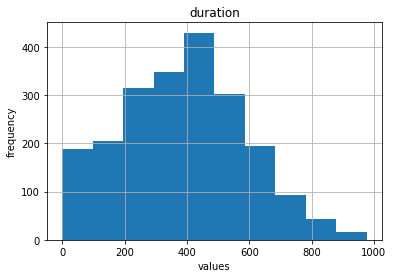

387.1693963500234

392.0

In [34]:
#df_merged2[['month', 'duration']].hist() 
df_merged2['duration'].hist() 
#plt.hist(df_merged2['month', 'duration'], bins = 20)
plt.title('duration')
plt.xlabel('values')
plt.ylabel('frequency')
plt.show()
display(df_merged2['duration'].mean())
display(df_merged2['duration'].median())

On the histogram above frequency(y axis) shows the number of data values in the corresponding group in the value column (x axis). This dataset is right skewed and we can clearly see some outliers to the right. This means we have have nonnormal data and the median is probably less than mean, which indicates presence of outliers. I check in the next line of code, and I was right: median is less, although not by much.

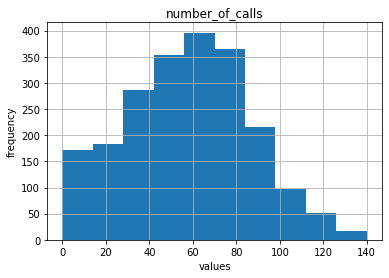

57.45999064108563

59.0

In [35]:
#df_merged2[['number_of_calls', 'month']].hist() 
df_merged2['number_of_calls'].hist() 
#plt.hist(df_merged2['month', 'duration'], bins = 20)
plt.title('number_of_calls')
plt.xlabel('values')
plt.ylabel('frequency')
plt.show()
display(df_merged2['number_of_calls'].mean())
display(df_merged2['number_of_calls'].median())

I ccome to the same conclusion for this histogram: the data is right skewed, there are probably ourliers and the median is less than the mean, although only marginally so.

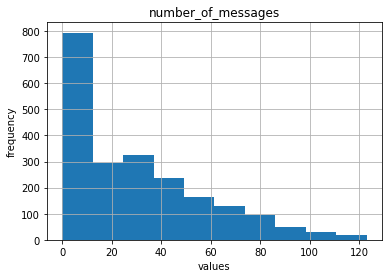

29.18437061300889

24.0

In [36]:
#df_merged2[['number_of_messages', 'month']].hist() 
df_merged2['number_of_messages'].hist() 
#plt.hist(df_merged2['month', 'duration'], bins = 20)
plt.title('number_of_messages')
plt.xlabel('values')
plt.ylabel('frequency')
plt.show()
display(df_merged2['number_of_messages'].mean())
display(df_merged2['number_of_messages'].median())

we can clearly see from the histogram above that there is a huge number of clienrs who didn't use messages at all. I will address this interesting fact later in the conclusion. It seems that messages are the least popular service.
The data is also right skewed and severely so, much more than the data on calls. We will also have to work with outliers here. Median is again less than the mean, this time by larger percent than before which could be predicted from the fact that data is more skewed. 

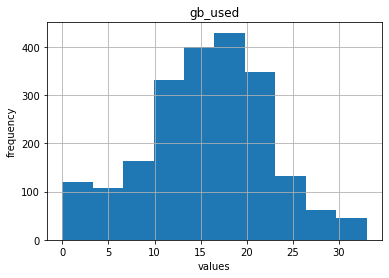

15.62096396817969

16.0

In [37]:

df_merged2['gb_used'].hist() 

plt.title('gb_used')
plt.xlabel('values')
plt.ylabel('frequency')
plt.show()
display(df_merged2['gb_used'].mean())
display(df_merged2['gb_used'].median())

Data is still skewed to the right and median is marginally less than the mean. 

Analyze customer behavior.
We can see that the number of messages and calls and the internet usage steadily increases over the months and drasticly increases in the last month of the year. 
From the histograms above we can also  infer the following:
The majority of users sent zero messages over the year; a huge percentage of them, it seems, don't use messages at all.
More than one third of users don't use calls. 
Around 25 percent of users don't use internet. 
From this we can infer that mobile internet is the most used service. 

In [38]:
df_merged2['duration'].describe()


count    2137.000000
mean      387.169396
std       198.993192
min         0.000000
25%       245.000000
50%       392.000000
75%       523.000000
max       977.000000
Name: duration, dtype: float64

In [39]:
df_merged2['number_of_calls'].describe()

count    2137.000000
mean       57.459991
std        28.872563
min         0.000000
25%        37.000000
50%        59.000000
75%        78.000000
max       140.000000
Name: number_of_calls, dtype: float64

In [40]:
df_merged2['number_of_messages'].describe()


count    2137.000000
mean       29.184371
std        28.221746
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       123.000000
Name: number_of_messages, dtype: float64

In [41]:
df_merged2['gb_used'].describe()

count    2137.000000
mean       15.620964
std         6.681455
min         0.000000
25%        12.000000
50%        16.000000
75%        20.000000
max        33.000000
Name: gb_used, dtype: float64

In [42]:
df_merged2['duration'].var()

39598.29057983207

In [43]:
df_merged2['number_of_calls'].var()

833.6249200373655

In [44]:
df_merged2['number_of_messages'].var()

796.4669278925442

In [45]:
df_merged2['gb_used'].var()

44.641844950480134

The code above shows variance mean and std for each relevant column in the merged dataframe

# in 4 cells above we see dispersion (variance) for each relevant column

In [46]:
dataSurf = df_merged2.query('plan == "surf"').reset_index()

In [47]:
dataUlt = df_merged2.query('plan == "ultimate"').reset_index()

In the cells above we separate the data by the plan to compare plans later.

In [48]:
dataUlt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 16 columns):
index                 659 non-null int64
user_id               659 non-null int64
month                 659 non-null float64
duration              659 non-null float64
mb_used               659 non-null float64
number_of_messages    659 non-null float64
number_of_calls       659 non-null float64
first_name            659 non-null object
last_name             659 non-null object
age                   659 non-null int64
city                  659 non-null object
reg_date              659 non-null datetime64[ns]
plan                  659 non-null object
churn_date            51 non-null datetime64[ns]
gb_used               659 non-null float64
profit                659 non-null float64
dtypes: datetime64[ns](2), float64(7), int64(3), object(4)
memory usage: 82.5+ KB


In the code below we put mean and sdt for both plans side to side for each category.

In [49]:
display(dataSurf['duration'].describe())
display(dataSurf['duration'].var())
display(dataUlt['duration'].describe())
display(dataUlt['duration'].var())

count    1478.000000
mean      386.774019
std       200.791374
min         0.000000
25%       245.000000
50%       390.500000
75%       530.000000
max       977.000000
Name: duration, dtype: float64

40317.17570909104

count    659.000000
mean     388.056146
std      195.047851
min        0.000000
25%      247.000000
50%      396.000000
75%      509.000000
max      926.000000
Name: duration, dtype: float64

38043.66401612464

In [50]:
display(dataSurf['number_of_calls'].describe())
display(dataSurf['number_of_calls'].var())
display(dataUlt['number_of_calls'].describe())
display(dataUlt['number_of_calls'].var())

count    1478.000000
mean       57.211773
std        29.030681
min         0.000000
25%        37.250000
50%        58.000000
75%        78.000000
max       140.000000
Name: number_of_calls, dtype: float64

842.7804435718452

count    659.000000
mean      58.016692
std       28.528789
min        0.000000
25%       36.000000
50%       60.000000
75%       77.000000
max      140.000000
Name: number_of_calls, dtype: float64

813.8918182195554

In [51]:
display(dataSurf['number_of_messages'].describe())
display(dataSurf['number_of_messages'].var())
display(dataUlt['number_of_messages'].describe())
display(dataUlt['number_of_messages'].var())

count    1478.000000
mean       27.612991
std        27.522215
min         0.000000
25%         2.000000
50%        22.500000
75%        43.000000
max       123.000000
Name: number_of_messages, dtype: float64

757.4723294393144

count    659.000000
mean      32.708649
std       29.448633
min        0.000000
25%        5.000000
50%       28.000000
75%       54.000000
max      123.000000
Name: number_of_messages, dtype: float64

867.2219767447223

In [52]:
display(dataSurf['gb_used'].describe())
display(dataSurf['gb_used'].var())
display(dataUlt['gb_used'].describe())
display(dataUlt['gb_used'].var())

count    1478.000000
mean       15.567659
std         6.746033
min         0.000000
25%        12.000000
50%        16.000000
75%        20.000000
max        33.000000
Name: gb_used, dtype: float64

45.50896012196027

count    659.000000
mean      15.740516
std        6.537782
min        0.000000
25%       12.000000
50%       16.000000
75%       20.000000
max       33.000000
Name: gb_used, dtype: float64

42.74259608599195

We can see from the histograms below that the maximum duration of calls was longer for the users of the surf plan,but there were also more missed calls. There's much more users who didn't use messages in the surf column. There's also more people who didn't use internet in the surf column. There's more 0's overall from this column.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff40547f610>]],
      dtype=object)

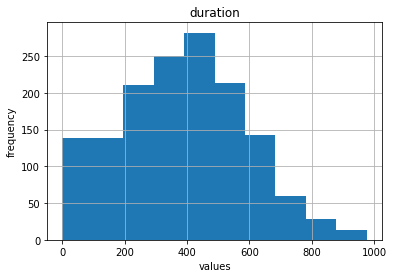

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff405369ad0>]],
      dtype=object)

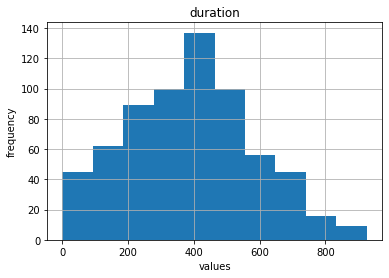

In [53]:
display(dataSurf.hist('duration'))
plt.xlabel('values')
plt.ylabel('frequency')
plt.show()
display(dataUlt.hist('duration'))
plt.xlabel('values')
plt.ylabel('frequency')
plt.show()

In [54]:
display(dataSurf['duration'].mean())
display(dataSurf['duration'].median())
display(dataUlt['duration'].mean())
display(dataUlt['duration'].median())

386.77401894451964

390.5

388.05614567526555

396.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4052a4b10>]],
      dtype=object)

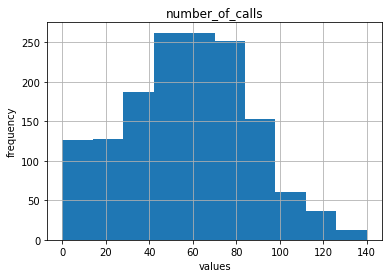

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff405266c50>]],
      dtype=object)

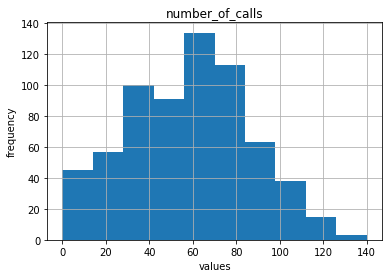

In [55]:
display(dataSurf.hist('number_of_calls'))
plt.xlabel('values')
plt.ylabel('frequency')
plt.show()
display(dataUlt.hist('number_of_calls'))
plt.xlabel('values')
plt.ylabel('frequency')
plt.show()

In [56]:
display(dataSurf['number_of_calls'].mean())
display(dataSurf['number_of_calls'].median())
display(dataUlt['number_of_calls'].mean())
display(dataUlt['number_of_calls'].median())

57.21177266576455

58.0

58.016691957511384

60.0

Here it is interesting: we see there's still more 0's in the surf database, so the theory that these clients call less stands. However, mean is less than median, even though data is still slightly skewed to the right. That's an esception to the mean-median rule, shows that while median is typically less than mean in right skewed data, it's not always the case.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4051ce390>]],
      dtype=object)

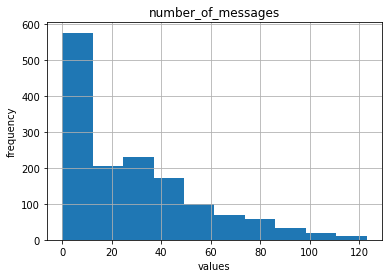

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff40517ed50>]],
      dtype=object)

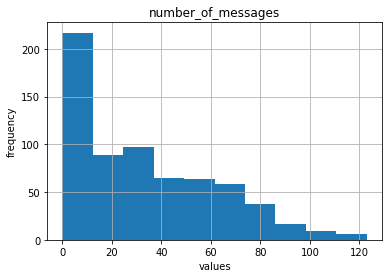

In [57]:
display(dataSurf.hist('number_of_messages'))
plt.xlabel('values')
plt.ylabel('frequency')
plt.show()
display(dataUlt.hist('number_of_messages'))
plt.xlabel('values')
plt.ylabel('frequency')
plt.show()

In [58]:
display(dataSurf['number_of_messages'].mean())
display(dataSurf['number_of_messages'].median())
display(dataUlt['number_of_messages'].mean())
display(dataUlt['number_of_messages'].median())

27.61299052774019

22.5

32.70864946889226

28.0

We can see that for both plans data is almost equally skewed to the right, but the means differ significantly. There's again more 0's for the surf plan users.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4050ab650>]],
      dtype=object)

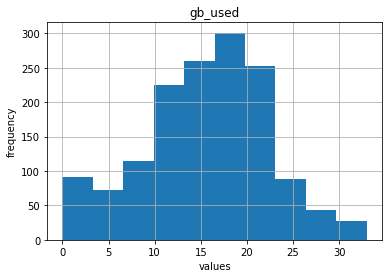

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff40501ec10>]],
      dtype=object)

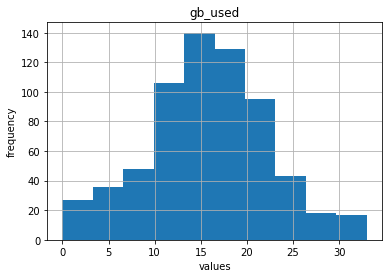

In [59]:
display(dataSurf.hist('gb_used'))
plt.xlabel('values')
plt.ylabel('frequency')
plt.show()
display(dataUlt.hist('gb_used'))
plt.xlabel('values')
plt.ylabel('frequency')
plt.show()

In [60]:
display(dataSurf['gb_used'].mean())
display(dataSurf['gb_used'].median())
display(dataUlt['gb_used'].mean())
display(dataUlt['gb_used'].median())

15.56765899864682

16.0

15.74051593323217

16.0

These histograms are very interesting. We see that this time the data for one of the plans is skewed more heavily to the right, but at the same time they have almost the same mean and median. I can make an assumption that perhaps profit from this particular service was similar for both plans since, as we have seen earlier after using describe() method, std for them is also almost the same.

In [61]:
display(dataUlt.info())
display(dataSurf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 16 columns):
index                 659 non-null int64
user_id               659 non-null int64
month                 659 non-null float64
duration              659 non-null float64
mb_used               659 non-null float64
number_of_messages    659 non-null float64
number_of_calls       659 non-null float64
first_name            659 non-null object
last_name             659 non-null object
age                   659 non-null int64
city                  659 non-null object
reg_date              659 non-null datetime64[ns]
plan                  659 non-null object
churn_date            51 non-null datetime64[ns]
gb_used               659 non-null float64
profit                659 non-null float64
dtypes: datetime64[ns](2), float64(7), int64(3), object(4)
memory usage: 82.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1478 entries, 0 to 1477
Data columns (total 16 columns):
index                 1478 non-null int64
user_id               1478 non-null int64
month                 1478 non-null float64
duration              1478 non-null float64
mb_used               1478 non-null float64
number_of_messages    1478 non-null float64
number_of_calls       1478 non-null float64
first_name            1478 non-null object
last_name             1478 non-null object
age                   1478 non-null int64
city                  1478 non-null object
reg_date              1478 non-null datetime64[ns]
plan                  1478 non-null object
churn_date            104 non-null datetime64[ns]
gb_used               1478 non-null float64
profit                1478 non-null float64
dtypes: datetime64[ns](2), float64(7), int64(3), object(4)
memory usage: 184.9+ KB


None

In [62]:
surfArr = dataSurf['profit'].sample(n=659, random_state=1)
ultArr = dataUlt['profit'].sample(n=659, random_state=1)
alpha = .05
results = st.ttest_ind(
        surfArr, 
        ultArr,
equal_var = False)
print('p-value:', results.pvalue)

p-value: 8.535046795683882e-34


Conclusion:
As we can see,the p-value is much, much lower than alpha so we have to reject the zero hypothesis. We have seen it also when using describe()method, the means were very different there too. That means the average profit definitely differs between the two plans.

In [63]:
df_merged2['city'].value_counts()

New York-Newark-Jersey City, NY-NJ-PA MSA          364
Los Angeles-Long Beach-Anaheim, CA MSA             131
Chicago-Naperville-Elgin, IL-IN-WI MSA              90
Dallas-Fort Worth-Arlington, TX MSA                 84
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA     71
                                                  ... 
Omaha-Council Bluffs, NE-IA MSA                      3
El Paso, TX MSA                                      2
Raleigh-Cary, NC MSA                                 2
Jacksonville, FL MSA                                 1
Cape Coral-Fort Myers, FL MSA                        1
Name: city, Length: 73, dtype: int64

In [64]:
dataNY = df_merged2[df_merged2.city.str.contains('NY-NJ')]

In [65]:
dataElse = df_merged2.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"').reset_index()

I separate the data by the city.

In [66]:
dataNY.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 53 to 2136
Data columns (total 15 columns):
user_id               364 non-null int64
month                 364 non-null float64
duration              364 non-null float64
mb_used               364 non-null float64
number_of_messages    364 non-null float64
number_of_calls       364 non-null float64
first_name            364 non-null object
last_name             364 non-null object
age                   364 non-null int64
city                  364 non-null object
reg_date              364 non-null datetime64[ns]
plan                  364 non-null object
churn_date            33 non-null datetime64[ns]
gb_used               364 non-null float64
profit                364 non-null float64
dtypes: datetime64[ns](2), float64(7), int64(2), object(4)
memory usage: 45.5+ KB


In [67]:
dataElse['city'].value_counts()

Los Angeles-Long Beach-Anaheim, CA MSA             131
Chicago-Naperville-Elgin, IL-IN-WI MSA              90
Dallas-Fort Worth-Arlington, TX MSA                 84
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA     71
Boston-Cambridge-Newton, MA-NH MSA                  69
                                                  ... 
Omaha-Council Bluffs, NE-IA MSA                      3
El Paso, TX MSA                                      2
Raleigh-Cary, NC MSA                                 2
Jacksonville, FL MSA                                 1
Cape Coral-Fort Myers, FL MSA                        1
Name: city, Length: 72, dtype: int64

I decided to check if the means of 'profit' column for NY and other areas are different, since we are testing if the average profit differs for NY and other areas.I chose 377 as it is the number of clients in the NY. The zero hypothesis(H0) is that the means are the same.
H0 is that the means of the profit columns of dataNY and dataElse are equal. Alternative hypothesis H1 is that the the means are not equal. 

In [68]:
dataElse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 16 columns):
index                 1773 non-null int64
user_id               1773 non-null int64
month                 1773 non-null float64
duration              1773 non-null float64
mb_used               1773 non-null float64
number_of_messages    1773 non-null float64
number_of_calls       1773 non-null float64
first_name            1773 non-null object
last_name             1773 non-null object
age                   1773 non-null int64
city                  1773 non-null object
reg_date              1773 non-null datetime64[ns]
plan                  1773 non-null object
churn_date            122 non-null datetime64[ns]
gb_used               1773 non-null float64
profit                1773 non-null float64
dtypes: datetime64[ns](2), float64(7), int64(3), object(4)
memory usage: 221.8+ KB


In [69]:
NYArr = dataNY['profit'].sample(n=364, random_state=1)
ELSEArr = dataElse['profit'].sample(n=364, random_state=1)
alpha = .05
results = st.ttest_ind(
        NYArr, 
        ELSEArr,
equal_var = False)
print('p-value:', results.pvalue)

p-value: 0.09976632324409263


Conclusion:
We can see that the p-value is higher than alpha value, so we can't reject the zero hypothesis. That means, we can't be sure that the means of two profit columns are different.  

General conclusion:
We can infer from the analysis above several things. First of all, in both plans the most popular service is mobile internet. There are still clients who don't use it for both plans, in the surf plan more. However, it is still the most used service. The least popular service, by a large margin, is messages. Thus, it would be beneficial to the company to advertise heavily the low prices for messages, since the clients tend to not use it that much. 
Another obvious trend, noticeable from the start, is that the clients tend to use the services more closer to the end of the year, especially in the last month. 
We can see also after testing the both hypothesis that we can't be sure profit in NY NJ is higher or lower than in other areas. However, we can confidently say that there's difference in profit between two plans. I would make an assumption from the information I got from looking at the mean, std, variance of the relevant columns and at the profit column that the more profitable plan is "Ultimate".